## Probably Distribution of actuator metrics
### Actuator metrics endpoint returns a lot of details on each call and it's hard to make sense of all the details just by looking at the data unless there is a clear anomaly. Like say a response time of 14x in an application where average response time is x. And it's even harder to correlate data just by looking, for example a higher thread count should result in higher memory consumption. To solve this problem we can use multivariate gaussian probabilty distribution.
So the idea is to capture actuator metrics over a long period of time and then identifying the parameters which can be used to identify probability of a single call to actuator metrics. And then analysing these low probability results to find actual anomalies.
Once we have a good number of actual anomalies, we can feed them to a neural network, and then this neural network will be responsible to find out the actual anomalies.

For the purpose of a POC I created a rest endpoint in a spring boot app, which was doing some IO operation and then hit this endpoint with different number of threads via a jmeter script for about 8 hours. And another service kept on hitting the metrics endpoint and kept persisting it in a db. This data is just to show how probability calculations can be done on metrics data and is not a representative of producation data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal
%matplotlib inline

Actuator data collected over time has been added in a csv file, the columns that are flushed to csv file are mem, mem_free, heap_committed, heap_init, heap_used, heap, nonheap_committed, nonheap_init, nonheap_used, threads_peak, threads_total_started, threads, classes, classes_loaded, gc_ps_scavenge_count, gc_ps_scavenge_time, gc_ps_marksweep_count, gc_ps_marksweep_time, gauge_response_test. Here we have excluded columns which are linearly increasing or which are constant like application uptime or available memory etc. 
Lets load this data in a numpy array.

In [3]:
X = np.genfromtxt ('ActuatorData.csv', delimiter=",", dtype=int)
X[0,0] = 126438
print (X.shape)

(1133, 19)
-1


One of the important things to consider while using multivariate or regular Gaussian anomaly detection is to make sure that we are using data points which roughly follow Gaussian/Normal distribution, i.e. mean value will have the maximum occurences and than occurences will be gradually decreasing on the left and right of mean. Generally when huge amount of data is collected, a lot of datapoints tend to follow Normal distrbution because of Central limit theorem. And if a datapoint is not following Gaussian distribution we can use varios techniques like taking logarithmic or exponential values to make that datapoint Gaussian. But for the purpose of this study we are only going to take datapoints which are already approximately Gaussain. Lets take a look at certain datapoints by plotting a histogram.

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0., 106.,
        268., 120.,  82., 254.,  36.,  21.,  10.,  12.,  12.,   9.,  16.,
         10.,   9.,   5.,   9.,   7.,   9.,  91.,  44.]),
 array([-1.00000000e+00,  1.56918333e+04,  3.13846667e+04,  4.70775000e+04,
         6.27703333e+04,  7.84631667e+04,  9.41560000e+04,  1.09848833e+05,
         1.25541667e+05,  1.41234500e+05,  1.56927333e+05,  1.72620167e+05,
         1.88313000e+05,  2.04005833e+05,  2.19698667e+05,  2.35391500e+05,
         2.51084333e+05,  2.66777167e+05,  2.82470000e+05,  2.98162833e+05,
         3.13855667e+05,  3.29548500e+05,  3.45241333e+05,  3.60934167e+05,
         3.76627000e+05,  3.92319833e+05,  4.08012667e+05,  4.23705500e+05,
         4.39398333e+05,  4.55091167e+05,  4.70784000e+05]),
 <a list of 30 Patch objects>)

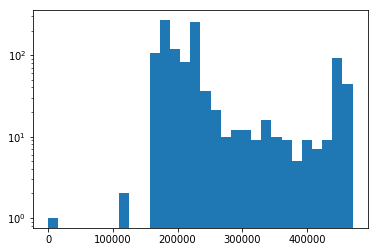

In [14]:
# plotting histogram for memory
plt.hist(X[:,0], bins=30)

(array([ 26.,  71.,  92., 133., 122., 131., 255.,  78.,  34.,  28.,  15.,
         16.,   9.,  12.,  11.,  11.,   8.,  10.,   9.,  10.,   6.,   6.,
          4.,   3.,   8.,   5.,   3.,   3.,   6.,   8.]),
 array([  1358.        ,  13639.13333333,  25920.26666667,  38201.4       ,
         50482.53333333,  62763.66666667,  75044.8       ,  87325.93333333,
         99607.06666667, 111888.2       , 124169.33333333, 136450.46666667,
        148731.6       , 161012.73333333, 173293.86666667, 185575.        ,
        197856.13333333, 210137.26666667, 222418.4       , 234699.53333333,
        246980.66666667, 259261.8       , 271542.93333333, 283824.06666667,
        296105.2       , 308386.33333333, 320667.46666667, 332948.6       ,
        345229.73333333, 357510.86666667, 369792.        ]),
 <a list of 30 Patch objects>)

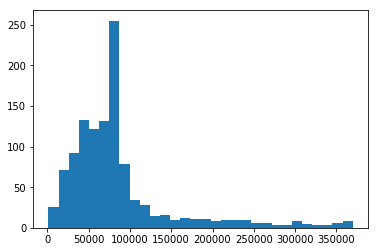

In [11]:
# plotting hist for mem_free
plt.hist(X[:,1], bins=30)

Above distribution is still not a very good Gaussian distribution but considering the fact that data is generated by a load simulation instead of actual prod data, we are going to consider this data point.

(array([ 18.,  48., 105., 130., 125., 171., 213.,  60.,  47.,  28.,  25.,
         22.,  13.,  10.,   9.,  10.,   8.,  11.,  11.,   7.,   6.,   8.,
          8.,   8.,   4.,   5.,   7.,   9.,   5.,   2.]),
 array([ 23575. ,  34683.1,  45791.2,  56899.3,  68007.4,  79115.5,
         90223.6, 101331.7, 112439.8, 123547.9, 134656. , 145764.1,
        156872.2, 167980.3, 179088.4, 190196.5, 201304.6, 212412.7,
        223520.8, 234628.9, 245737. , 256845.1, 267953.2, 279061.3,
        290169.4, 301277.5, 312385.6, 323493.7, 334601.8, 345709.9,
        356818. ]),
 <a list of 30 Patch objects>)

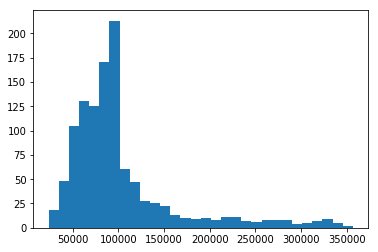

In [16]:
#heap_used
plt.hist(X[:,4], bins=30)

(array([ 13., 232.,  37., 118., 134.,  92.,  84.,  88.,  51.,  46.,  56.,
         47.,  29.,  21.,  16.,  20.,  14.,   6.,   4.,   4.,   3.,   2.,
          3.,   5.,   3.,   2.,   2.,   0.,   0.,   1.]),
 array([  1.        ,   6.63333333,  12.26666667,  17.9       ,
         23.53333333,  29.16666667,  34.8       ,  40.43333333,
         46.06666667,  51.7       ,  57.33333333,  62.96666667,
         68.6       ,  74.23333333,  79.86666667,  85.5       ,
         91.13333333,  96.76666667, 102.4       , 108.03333333,
        113.66666667, 119.3       , 124.93333333, 130.56666667,
        136.2       , 141.83333333, 147.46666667, 153.1       ,
        158.73333333, 164.36666667, 170.        ]),
 <a list of 30 Patch objects>)

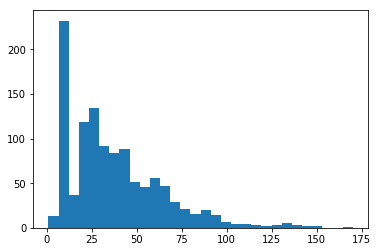

In [17]:
#response
plt.hist(X[:,18], bins=30)

There is an early peak, but on a large dataset, response will also follow Normal dirtribution, hence we are going to consider it.

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  18.,   4.,  18.,  36.,  52., 112.,  49.,  48.,  39.,   1.,
         45.,  36.,  63., 217.,   1., 103.,  47., 243.]),
 array([56316.        , 56363.43333333, 56410.86666667, 56458.3       ,
        56505.73333333, 56553.16666667, 56600.6       , 56648.03333333,
        56695.46666667, 56742.9       , 56790.33333333, 56837.76666667,
        56885.2       , 56932.63333333, 56980.06666667, 57027.5       ,
        57074.93333333, 57122.36666667, 57169.8       , 57217.23333333,
        57264.66666667, 57312.1       , 57359.53333333, 57406.96666667,
        57454.4       , 57501.83333333, 57549.26666667, 57596.7       ,
        57644.13333333, 57691.56666667, 57739.        ]),
 <a list of 30 Patch objects>)

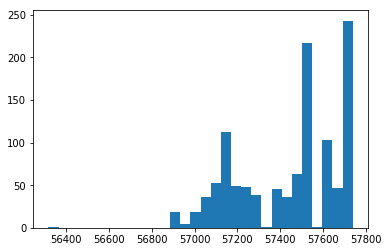

In [21]:
#Threads_total_started
plt.hist(X[:,8], bins=30)

If you look at the jmeter plan attached in the repo, you will find that I have ran the app with 20 users, than 30 and so on and I have run it for maximum time with 100 users, hence we are getting skewed data. Generally for users also we would have a mean value with maximum occurence. And properties like threads etc. will follow a simmilar pattern. But for this example I am not considering threads.

So for the time being we are going to work with mem_free, heap_used and response_time.

For calculating probability of a data row(an actuator instance) we have two methods.
1) Probability of a given mem_free will be 
(1/√2*√Π*σ)*e^(-(x-μ)/(2*σ^2)) 
where x is mem_free, μ is mean of all mem_free values, and σ is variance.
So to calculate probability of a given actuator metrics result we will need P(mem_free)*P(heap_used)*P(response).
The problem with this method is it does not consider relation between multiple variables.
Hence we are going to use multivariate normal distribution
P(actuator result) = (1/((2Π)^n/2)*|∑|)*e^(-.5*(x-μ)′*∑^-1*(x-μ))
where ∑ = covariance matrix, |∑| = detrminant of covariance matrix, μ= vector with all means for all datapoints, n= number of datapoints(in our case 3)
Lets write methods to calculate mean, variance, covariance matrix and probability.

In [22]:
def getMeanAndVariance(X):
    (m,n) = X.shape
    # initializing mu(mean) and sigma2(variance)
    mu = np.zeros((n,1))
    sigma2 = np.zeros((n,1))
    # mean
    mu = np.sum(X, axis=0)/m
    tempSigma = X - mu
    tempSigma2 = np.power(tempSigma, 2)
    sigma2 = np.sum(tempSigma2, axis=0)/m
    return (mu, sigma2)

In [23]:
def getCovariance(X):
    return np.cov(X, rowvar=False)

In [31]:
def calculateProbabilities(X, mean, cov):
    var = multivariate_normal(mean, cov, allow_singular=True)
    p = np.zeros(len(X))
    for i in range(len(X)):
        p[i] = var.pdf(X[i])
    return p

Let's calulate probability for all entries.

In [32]:
(mean, var1) = getMeanAndVariance(X)
cov = getCovariance(X)
p = calculateProbabilities(X, mean, cov)
print (mean)
print (cov)
print (p)

[2.45907277e+05 8.56634519e+04 1.88575520e+05 6.55360000e+04
 1.02913583e+05 9.13920000e+05 6.03781818e+04 2.49600000e+03
 5.74433786e+04 8.38808473e+01 8.88808473e+01 6.19567520e+01
 6.22587820e+03 6.26780229e+03 1.77843883e+04 8.60245481e+04
 3.13089144e+01 1.09414440e+04 3.69796999e+01]
[[ 8.46113390e+09  4.54940540e+09  8.44672055e+09  0.00000000e+00
   3.89724577e+09  0.00000000e+00 -3.79262800e+06  0.00000000e+00
  -1.30583527e+07 -1.50893461e+06 -1.50893461e+06 -1.22169167e+06
   1.14371632e+06 -1.05329840e+04 -6.00077927e+08 -2.74821328e+09
  -8.91456056e+05 -3.50103498e+08 -6.58948202e+05]
 [ 4.54940540e+09  4.38002251e+09  4.54841080e+09  0.00000000e+00
   1.68329015e+08  0.00000000e+00 -2.10557655e+06  0.00000000e+00
  -6.96608547e+06 -8.00086778e+05 -8.00086778e+05 -7.31220926e+05
   6.01347757e+05 -9.04620475e+03 -3.22208591e+08 -1.47106091e+09
  -4.64300106e+05 -1.85581130e+08 -3.94490201e+05]
 [ 8.44672055e+09  4.54841080e+09  8.44673149e+09  0.00000000e+00
   3.89825104